In [1]:
from hessian import hessian

In [2]:
import sys
import os
from time import time
from importlib import reload
import re
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from cv2 import imread, imwrite
import matplotlib.pylab as plt

sys.path.append("D:\Github\pytorch-caffe")
from caffenet import *

In [3]:
from IPython import display
from time import sleep
%matplotlib notebook

In [4]:
%matplotlib inline

https://stackoverflow.com/questions/42998009/clear-matplotlib-figure-in-jupyter-python-notebook

## Prepare Nets

In [5]:
# Check GPU usage
print(torch.cuda.current_device())
# print(torch.cuda.device(0))
if torch.cuda.is_available():
    print(torch.cuda.device_count(), " GPU is available:", torch.cuda.get_device_name(0))

0
1  GPU is available: GeForce GTX 1060 6GB


In [6]:
basedir = r"D:\Generator_DB_Windows\nets"
protofile = os.path.join(basedir, r"caffenet\caffenet.prototxt") # 'resnet50/deploy.prototxt'
weightfile = os.path.join(basedir, 'bvlc_reference_caffenet.caffemodel') # 'resnet50/resnet50.caffemodel'
save_path = os.path.join(basedir, r"caffenet\caffenet_state_dict.pt")
net = CaffeNet(protofile)
print(net)
if os.path.exists(save_path):
    net.load_state_dict(torch.load(save_path))
else:
    net.load_weights(weightfile)
    torch.save(net.state_dict(), save_path)
net.eval()

create conv1                (   3 x  227 x  227) -> (  96 x   55 x   55)
create relu1                (  96 x   55 x   55) -> (  96 x   55 x   55)
create pool1                (  96 x   55 x   55) -> (  96 x   27 x   27)
create norm1                (  96 x   27 x   27) -> (  96 x   27 x   27)
create conv2                (  96 x   27 x   27) -> ( 256 x   27 x   27)
create relu2                ( 256 x   27 x   27) -> ( 256 x   27 x   27)
create pool2                ( 256 x   27 x   27) -> ( 256 x   13 x   13)
create norm2                ( 256 x   13 x   13) -> ( 256 x   13 x   13)
create conv3                ( 256 x   13 x   13) -> ( 384 x   13 x   13)
create relu3                ( 384 x   13 x   13) -> ( 384 x   13 x   13)
create conv4                ( 384 x   13 x   13) -> ( 384 x   13 x   13)
create relu4                ( 384 x   13 x   13) -> ( 384 x   13 x   13)
create conv5                ( 384 x   13 x   13) -> ( 256 x   13 x   13)
create relu5                ( 256 x   13 x   13) ->

CaffeNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (norm1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (norm2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace=True)
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (relu4): ReLU(inplace=True)
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (relu5): ReLU(inplace=True)
  (pool5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (fc6): Sequential(
    (0): view(nB, -1)
    (1)

In [7]:
basedir = r"D:/Generator_DB_Windows/nets"
save_path = os.path.join(basedir, r"upconv/fc6/generator_state_dict.pt")
protofile = os.path.join(basedir, r"upconv/fc6/generator.prototxt") # 'resnet50/deploy.prototxt'
weightfile = os.path.join(basedir, r'upconv/fc6/generator.caffemodel') # 'resnet50/resnet50.caffemodel'
Generator = CaffeNet(protofile)
print(Generator)
if os.path.exists(save_path):
    Generator.load_state_dict(torch.load(save_path))
else:
    Generator.load_weights(weightfile)
    Generator.save(Generator.state_dict(), save_path)
Generator.eval()

create defc7                (4096 x    1 x    1) -> (4096 x    1 x    1)
create relu_defc7           (4096 x    1 x    1) -> (4096 x    1 x    1)
create defc6                (4096 x    1 x    1) -> (4096 x    1 x    1)
create relu_defc6           (4096 x    1 x    1) -> (4096 x    1 x    1)
create defc5                (4096 x    1 x    1) -> (4096 x    1 x    1)
create relu_defc5           (4096 x    1 x    1) -> (4096 x    1 x    1)
create reshape              (4096 x    1 x    1) -> ( 256 x    4 x    4)
create deconv5              ( 256 x    4 x    4) -> ( 256 x    8 x    8)
create relu_deconv5         ( 256 x    8 x    8) -> ( 256 x    8 x    8)
create conv5_1              ( 256 x    8 x    8) -> ( 512 x    8 x    8)
create relu_conv5_1         ( 512 x    8 x    8) -> ( 512 x    8 x    8)
create deconv4              ( 512 x    8 x    8) -> ( 256 x   16 x   16)
create relu_deconv4         ( 256 x   16 x   16) -> ( 256 x   16 x   16)
create conv4_1              ( 256 x   16 x   16) ->

CaffeNet(
  (defc7): Sequential(
    (0): view(nB, -1)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
  )
  (relu_defc7): LeakyReLU(negative_slope=0.3, inplace=True)
  (defc6): Sequential(
    (0): view(nB, -1)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
  )
  (relu_defc6): LeakyReLU(negative_slope=0.3, inplace=True)
  (defc5): Sequential(
    (0): view(nB, -1)
    (1): Linear(in_features=4096, out_features=4096, bias=True)
  )
  (relu_defc5): LeakyReLU(negative_slope=0.3, inplace=True)
  (reshape): Reshape(dims=[1, 256, 4, 4])
  (deconv5): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu_deconv5): LeakyReLU(negative_slope=0.3, inplace=True)
  (conv5_1): ConvTranspose2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_conv5_1): LeakyReLU(negative_slope=0.3, inplace=True)
  (deconv4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (relu_deconv4): LeakyReLU(negativ

In [8]:
net.verbose = False
Generator.verbose = False
net.requires_grad_(requires_grad=False)
Generator.requires_grad_(requires_grad=False)
for param in net.parameters():
    param.requires_grad = False
for param in Generator.parameters():
    param.requires_grad = False

In [9]:
import net_utils
#import utils
detfmr = net_utils.get_detransformer(net_utils.load('generator'))
tfmr = net_utils.get_transformer(net_utils.load('caffe-net'))

## Optimization

In [25]:
BGR_mean = torch.tensor([104.0, 117.0, 123.0])
BGR_mean = torch.reshape(BGR_mean,(1,3,1,1))

In [10]:
def display_image(ax, out_img):
    deproc_img = detfmr.deprocess('data', out_img.data.numpy())
    ax.imshow(np.clip(deproc_img, 0, 1)) 

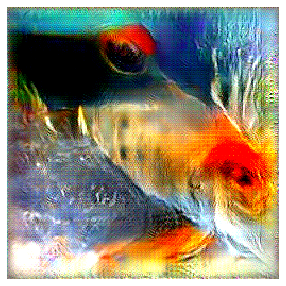

190 steps, Neuron activation 71.989


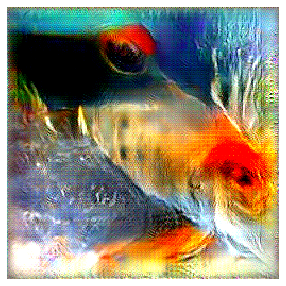

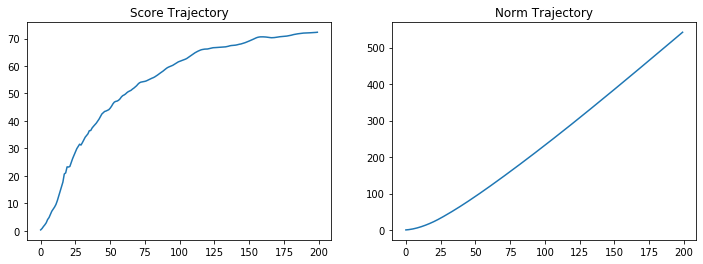

In [34]:
feat = 0.0001*np.random.rand(1, 4096)
feat = torch.from_numpy(np.float32(feat))
feat = Variable(feat, requires_grad = True)
offset = 16
pipe_optimizer = optim.SGD([feat], lr=0.05,momentum=0.3,dampening=0.1) # Seems Adam is not so good, Adagrad ... is not so 
score = []
feat_norm = []
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_axis_off()
for step in range(200): 
#     if step%5==0:
#         pipe_optimizer.zero_grad()
    blobs = Generator(feat) # forward the feature vector through the GAN
    out_img = blobs['deconv0'] # get raw output image from GAN
#     center_img = out_img[:, :, offset:-offset, offset:-offset]
#     blobs_CNN = net(center_img)
    resz_out_img = F.interpolate(out_img, (224, 224), mode='bilinear', align_corners=True)
    blobs_CNN = net(resz_out_img)
    neg_activ = - blobs_CNN['fc8'][0,1]
    neg_activ.backward()
    pipe_optimizer.step()
    score.append(- neg_activ.data.item())
    feat_norm.append(feat.norm(p=2).data.item())
    if step%10==0:
        display_image(ax, out_img)
        display.clear_output(wait=True)
        display.display(fig)
        print("%d steps, Neuron activation %.3f"%(step, - neg_activ.data.item() ))

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(np.arange(len(score)), score)
plt.title("Score Trajectory")
plt.subplot(1,2,2)
plt.plot(np.arange(len(score)), feat_norm)
plt.title("Norm Trajectory")
plt.show()

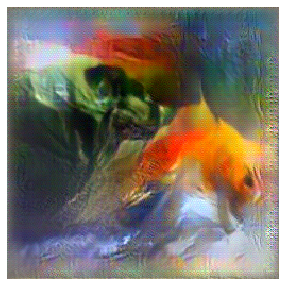

190 steps, Neuron activation 91.614


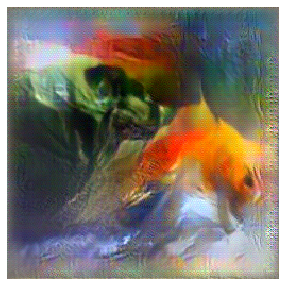

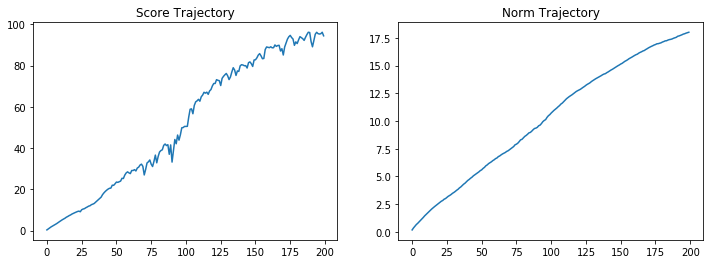

In [35]:
feat = 0.0001*np.random.rand(1, 4096)
feat = torch.from_numpy(np.float32(feat))
feat = Variable(feat, requires_grad = True)
offset = 16
pipe_optimizer = optim.SGD([feat], lr=0.05,momentum=0.3,dampening=0.1) # Seems Adam is not so good, Adagrad ... is not so 
score = []
feat_norm = []
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_axis_off()
for step in range(200): 
    if step%1==0:
        pipe_optimizer.zero_grad()
    blobs = Generator(feat) # forward the feature vector through the GAN
    out_img = blobs['deconv0'] # get raw output image from GAN
#     center_img = out_img[:, :, offset:-offset, offset:-offset]
#     blobs_CNN = net(center_img)
    resz_out_img = F.interpolate(out_img, (224, 224), mode='bilinear', align_corners=True)
    blobs_CNN = net(resz_out_img)
    neg_activ = - blobs_CNN['fc8'][0,1]
    neg_activ.backward()
    pipe_optimizer.step()
    score.append(- neg_activ.data.item())
    feat_norm.append(feat.norm(p=2).data.item())
    if step%10==0:
        display_image(ax, out_img)
        display.clear_output(wait=True)
        display.display(fig)
        print("%d steps, Neuron activation %.3f"%(step, - neg_activ.data.item() ))

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(np.arange(len(score)), score)
plt.title("Score Trajectory")
plt.subplot(1,2,2)
plt.plot(np.arange(len(score)), feat_norm)
plt.title("Norm Trajectory")
plt.show()

In [26]:
out_img + BGR_mean

tensor([[[[115.3209, 100.0384,  97.6687,  ..., 118.9037,  94.4798,  94.7262],
          [109.9809,  96.9575, 109.6566,  ..., 111.3086, 110.4233, 108.7790],
          [ 97.7569, 105.9163,  97.7645,  ..., 114.4055, 110.8220, 102.8828],
          ...,
          [108.5706, 106.5273, 103.9527,  ..., 115.5608, 110.9643, 108.4537],
          [105.8967, 103.6941, 102.2308,  ..., 104.2410, 111.1555, 105.8511],
          [105.8425, 108.2619, 116.0139,  ..., 109.6964, 106.1452, 102.6357]],

         [[119.3307, 125.1371, 102.4040,  ..., 124.7681, 101.7906, 107.6383],
          [127.6233, 116.1674, 116.6431,  ..., 121.4799, 122.0592, 118.2949],
          [122.2012, 124.5195, 120.1965,  ..., 128.3437, 120.2408, 124.1754],
          ...,
          [120.5093, 119.9156, 114.6513,  ..., 125.4571, 124.4187, 116.6210],
          [114.9443, 112.8712, 113.0835,  ..., 118.5078, 121.6531, 121.5191],
          [120.2577, 122.9258, 120.6151,  ..., 128.2067, 116.8808, 119.0515]],

         [[116.4456, 132.8235,

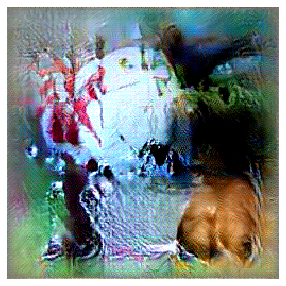

190 steps, Neuron activation 327.213


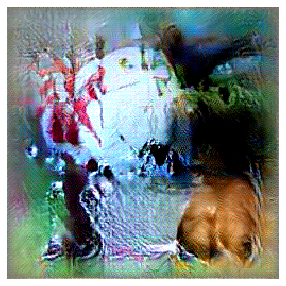

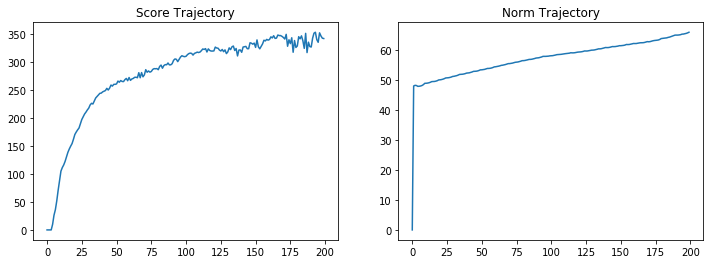

In [36]:
feat = 0.0001*np.random.rand(1, 4096)
feat = torch.from_numpy(np.float32(feat))
feat = Variable(feat, requires_grad = True)
offset = 16
pipe_optimizer = optim.SGD([feat], lr=0.05) # Seems Adam is not so good, Adagrad ... is not so 
score = []
feat_norm = []
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.set_axis_off()
for step in range(200): 
    if step%5==0:
        pipe_optimizer.zero_grad()
    blobs = Generator(feat) # forward the feature vector through the GAN
    out_img = blobs['deconv0'] # get raw output image from GAN
    # Add code to simulate the deprocessing and processing. deprocess('data', x); np.clip(x, 0, 1);  tfm.preprocess('data', img); 
#     center_img = out_img[:, :, offset:-offset, offset:-offset]
#     blobs_CNN = net(center_img)
    clamp_out_img = torch.clamp(out_img + BGR_mean, 0, 255) 
    resz_out_img = F.interpolate(clamp_out_img - BGR_mean, (224, 224), mode='bilinear', align_corners=True)
    blobs_CNN = net(resz_out_img)
    neg_activ = - blobs_CNN['conv5'][0,5,10,10]
    neg_activ.backward()
    pipe_optimizer.step()
    score.append(- neg_activ.data.item())
    feat_norm.append(feat.norm(p=2).data.item())
    if feat.grad.norm()<1E-10:
        print("%d steps, No Gradient, Neuron activation %.3f, Re-initialize"%(step, - neg_activ.data.item() ))
        feat = Variable( 0.75 * torch.randn((1, 4096)), requires_grad = True)
        pipe_optimizer = optim.SGD([feat], lr=0.05)
        continue
    if step%10==0:
        display_image(ax, out_img)
        display.clear_output(wait=True)
        display.display(fig)
        print("%d steps, Neuron activation %.3f"%(step, - neg_activ.data.item() ))

def display_image(ax, out_img):
    deproc_img = detfmr.deprocess('data', out_img.data.numpy())
    ax.imshow(np.clip(deproc_img, 0, 1)) 
    
# deproc_img = detfmr.deprocess('data', out_img.data.numpy())
# plt.imshow(np.clip(deproc_img, 0, 1))# .view([224,224,3])
# plt.axis('off')
# plt.show()

plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(np.arange(len(score)), score)
plt.title("Score Trajectory")
plt.subplot(1,2,2)
plt.plot(np.arange(len(score)), feat_norm)
plt.title("Norm Trajectory")
plt.show()

In [15]:
feat

tensor([[-0.0086,  0.0035, -0.0016,  ..., -0.0097,  0.0031, -0.0107]],
       grad_fn=<AddBackward0>)

In [14]:
blobs = Generator(feat) # forward the feature vector through the GAN
out_img = blobs['deconv0'] # get raw output image from GAN
center_img = out_img[:, :, offset:-offset, offset:-offset]
blobs_CNN = net(center_img)
neg_activ = - blobs_CNN['fc8'][0,1]

D:\Github\pytorch-caffe\caffenet.py:201: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x.view(-1, dims))


In [12]:
feat.grad.norm()

tensor(16.2399)

In [15]:
neg_activ.backward(retain_graph=True)

In [11]:
feat.grad.norm()

tensor(17.4291)

In [ ]:
unit

In [29]:
t0 = time()
blobs = Generator(feat) # forward the feature vector through the GAN
out_img = blobs['deconv0'] # get raw output image from GAN
#center_img = out_img[:, :, offset:-offset, offset:-offset]
clamp_out_img = torch.clamp(out_img + BGR_mean, 0, 255) 
resz_out_img = F.interpolate(clamp_out_img - BGR_mean, (224, 224), mode='bilinear', align_corners=True)
blobs_CNN = net(resz_out_img)
neg_activ = - blobs_CNN['fc6'][0,1]
gradient = torch.autograd.grad(neg_activ,feat,retain_graph=True)[0] # First order gradient
%time H = hessian(neg_activ,feat, create_graph=False) # Second order gradient
t1 = time()
print(t1-t0) # Each Calculation may take 1050s esp for deep layer in the network! 

D:\Github\pytorch-caffe\caffenet.py:201: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x.view(-1, dims))


Wall time: 19min 43s
1183.4231719970703


In [30]:
np.savez("hessian_result2.npz",z=feat.detach().numpy(),activation=-neg_activ.detach().numpy(),
         grad=gradient.numpy(),H=H.detach().numpy())

In [31]:
%time  eigval, eigvec = np.linalg.eigh(H.detach().numpy()) # eigen decomposition for a symmetric array! ~ 5.7 s 
g = gradient.numpy()
%time  g = np.sort(g)

Wall time: 5.99 s
Wall time: 997 µs


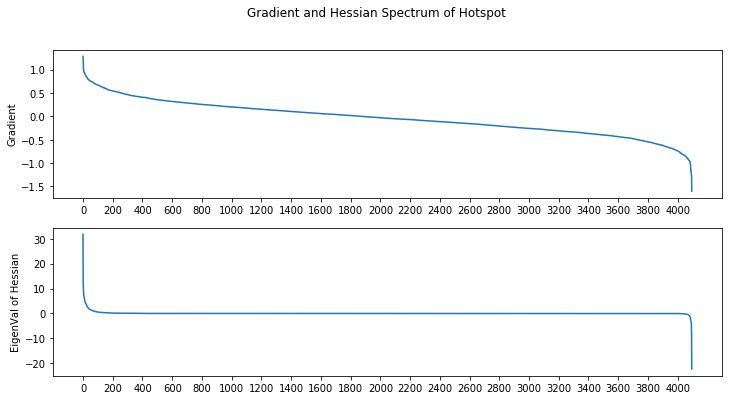

In [32]:
plt.figure(figsize=[12,6])
plt.subplot(211)
plt.plot(g[0,::-1])
plt.xticks(np.arange(0,4200,200))
plt.ylabel("Gradient")
plt.subplot(212)
plt.plot(eigval[::-1])
plt.xticks(np.arange(0,4200,200))
plt.ylabel("EigenVal of Hessian")
plt.suptitle("Gradient and Hessian Spectrum of Hotspot")
plt.show()

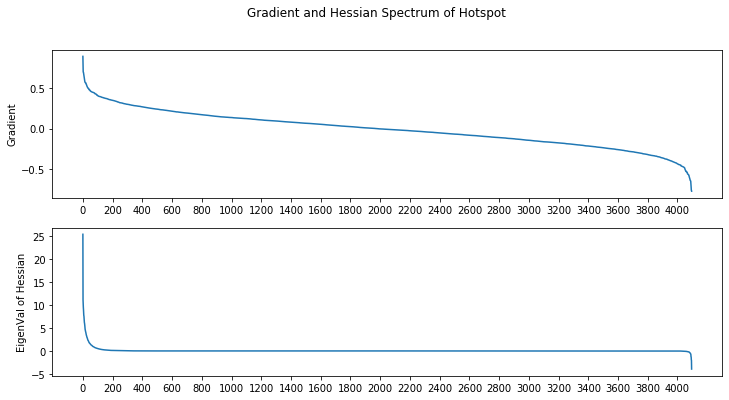

In [92]:
plt.figure(figsize=[12,6])
plt.subplot(211)
plt.plot(g[0,::-1])
plt.xticks(np.arange(0,4200,200))
plt.ylabel("Gradient")
plt.subplot(212)
plt.plot(eigval[::-1])
plt.xticks(np.arange(0,4200,200))
plt.ylabel("EigenVal of Hessian")
plt.suptitle("Gradient and Hessian Spectrum of Hotspot")
plt.show()

## Hessian Computation Playground

In [26]:
z = Variable(torch.tensor([10.0, 5]), requires_grad = True)

In [28]:
hessian(z.sum()**3,z)

tensor([[90., 90.],
        [90., 90.]])

In [101]:
- blobs_CNN['conv5'][0,100,10,10]

tensor(-0., grad_fn=<NegBackward>)

## Plotting playground

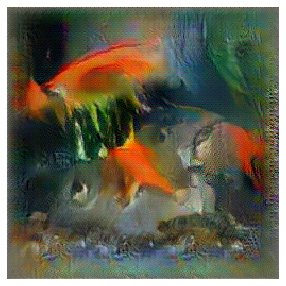

In [35]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
# ax.imshow(np.clip(deproc_img/2, 0, 1))
ax.set_axis_off()
# fig.canvas.draw_idle()
def update_plot(img):
    # set view angle
    ax.imshow(img)
    #fig.canvas.draw_idle()
for i in range(0,10):
    update_plot(np.clip(deproc_img*i/10, 0, 1))
    display.display(fig)
    display.clear_output(wait = True)
    plt.pause(0.5)
    #sleep(0.5)

In [14]:
plt.show(fig)

C:\Users\ponce\.conda\envs\caffe36\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Passing arguments to show(), other than passing 'block' by keyword, is deprecated 3.1, and support for it will be removed in 3.3.
  """Entry point for launching an IPython kernel.


In [ ]:

from PIL import Image
from time import sleep
dynimage = DynamicImage()
class DynamicImage(object):
    def UpdateFromPIL(self, new_img):
        from io import BytesIO
        from IPython import display
        display.clear_output(wait=True)
        image = BytesIO()
        new_img.save(image, format='png')
        display.display(display.Image(image.getvalue()))

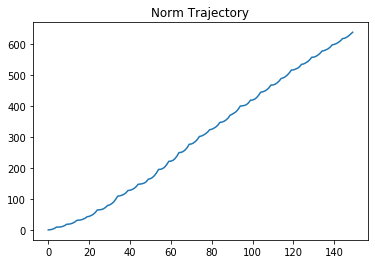

In [10]:
plt.plot(np.arange(len(score)), np.array(feat_norm)**2)
plt.title("Squared Norm Trajectory")
plt.show()